# Splice scorers


This notebook shows distribution of scores of variants as calculated by *EselatorSimulations* code.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True)
figsize=(16, 8)

## Load the positive cases
### Info
The file `scorers_all.tsv` that is being read contains biocurated variants that are located in `hrmd/data/splicing/training/hca-1.0.7/json`. Variants have been exported into `data/eselator-simulations/phenopackets` using *Hpo Case Annotator*'s export function.

### How to create
This dataset has been created by running:

```bash
java -jar simulations-cli-0.2.0.jar --splice-scorer --exomiser.data-directory=/home/ielis/data/exomiser-data --output=/home/ielis/data/eselator-simulations/scorers_all.tsv
--pp=/home/ielis/data/eselator-simulations/phenopackets/Aceto-2005-APC.json
--pp=/home/ielis/data/eselator-simulations/phenopackets/Aguilar-Ramirez-2009-C5.json
--pp=/home/ielis/data/eselator-simulations/phenopackets/Aldahmesh-2009-CTNS.json

# ... omitted for brevity

--pp=/home/ielis/data/eselator-simulations/phenopackets/Zatkova-2004-NF1.json
```

In [2]:
POS_PATH = "/home/ielis/data/eselator-simulations/scorers_all.tsv"
positive_cases = pd.read_table(POS_PATH)
positive_cases.head(n=1)

,PP_ID,VARIANT,VCLASS,PATHOMECHANISM,CONSEQUENCE,CANONICAL_ACCEPTOR,CANONICAL_DONOR,CRYPTIC_ACCEPTOR,CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS,CRYPTIC_DONOR,CRYPTIC_DONOR_FOR_DONOR_VARIANTS,HEXAMER
0,Aceto-2005-APC,5:112128142G>A,splicing,splicing|3ss|disrupted,Alternative/cryptic 3' splice site,9.960002,NaN,NaN,-0.547678,NaN,NaN,NaN


## Load ClinVar variants

### Info

The file `clinvar.tsv` contains ClinVar variants with `CLNSIG=Benign`. The variants have been annotated with splicing scorers.

### How to create
This dataset has been created by running

```bash
java -jar simulations-cli-0.2.0.jar --clinvar-scorer --exomiser.data-directory=/home/ielis/data/exomiser-data --clinvar-vcf=/home/ielis/tempelhof/clinVar/20190408/clinvar.filtered.vcf.gz --output=/home/ielis/data/eselator-simulations/clinvar.tsv
```

In [3]:
CLINVAR_PATH = "/home/ielis/data/eselator-simulations/clinvar_benign.tsv"

clinvar_benign_cases = pd.read_table(CLINVAR_PATH)
clinvar_benign_cases.head(n=1)

,VARIANT,CANONICAL_ACCEPTOR,CANONICAL_DONOR,CRYPTIC_ACCEPTOR,CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS,CRYPTIC_DONOR,CRYPTIC_DONOR_FOR_DONOR_VARIANTS,HEXAMER
0,1:949422G>A,NaN,NaN,-3.78016,NaN,-4.289216,NaN,0.801761


## Merge scores into a single dataframe

Both `clinvar_benign_cases` and `positive_cases` share score columns: `['CANONICAL_ACCEPTOR', 'CANONICAL_DONOR', 'CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS', 'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS', 'HEXAMER']`.

Here, additional `SOURCE` column will be added, where values `ClinVar`, and `Curated` will be present.

In [4]:
SCORER_NAMES = ['Canonical\ndonor',  'Cryptic\ndonor', 'Cryptic donor\nfor variants\nin donor site',
                  'Canonical\nacceptor','Cryptic\nacceptor', 'Cryptic acceptor\nfor variants\nin acceptor site',
                  'Hexamer']
SCORER_COLUMNS = ['CANONICAL_DONOR',  'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS',
                  'CANONICAL_ACCEPTOR','CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS',
                  'HEXAMER']
COLUMNS = ['VARIANT'] + SCORER_COLUMNS

# Join positive and ClinVar benign variant data
joined = pd.concat([clinvar_benign_cases.loc[:, COLUMNS].assign(SOURCE='ClinVar'), 
 positive_cases.loc[:, COLUMNS].assign(SOURCE='Curated')])

# Melt to make plotting easier
id_vars = ["VARIANT", "SOURCE"]
joined_melted = joined.melt(id_vars=id_vars, value_vars=SCORER_COLUMNS, var_name="SCORER", value_name="SCORE")
joined_melted.head(n=1)

,VARIANT,SOURCE,SCORER,SCORE
0,1:949422G>A,ClinVar,CANONICAL_DONOR,NaN


/home/ielis/anaconda3/envs/eselearner/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


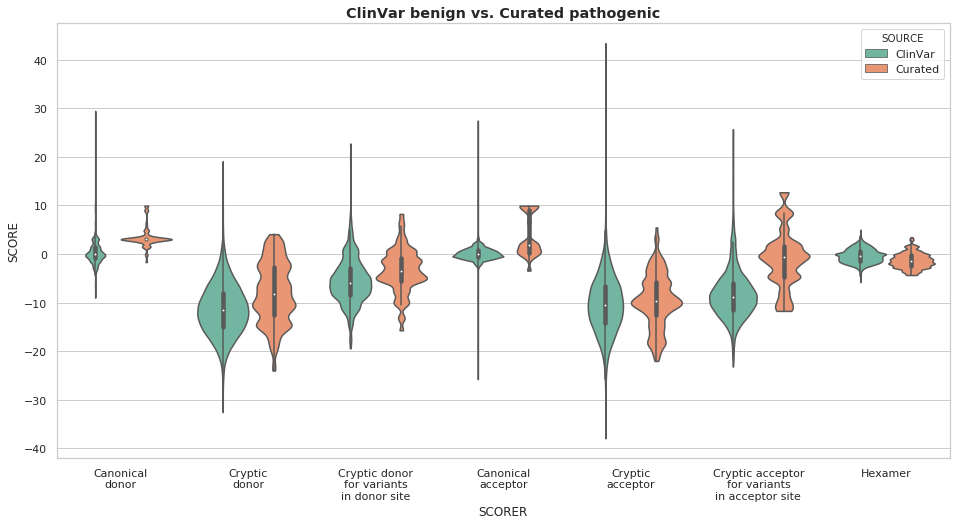

In [5]:
fig, ax = plt.subplots(figsize=figsize)
split_violin = sns.violinplot(x="SCORER", y="SCORE", hue="SOURCE", palette="Set2", bw=.15, cut=0,
                              data=joined_melted, ax=ax) 
xticklabels = split_violin.set_xticklabels(SCORER_NAMES)
ax_title = ax.set_title("ClinVar benign vs. Curated pathogenic", size='x-large', weight='bold')

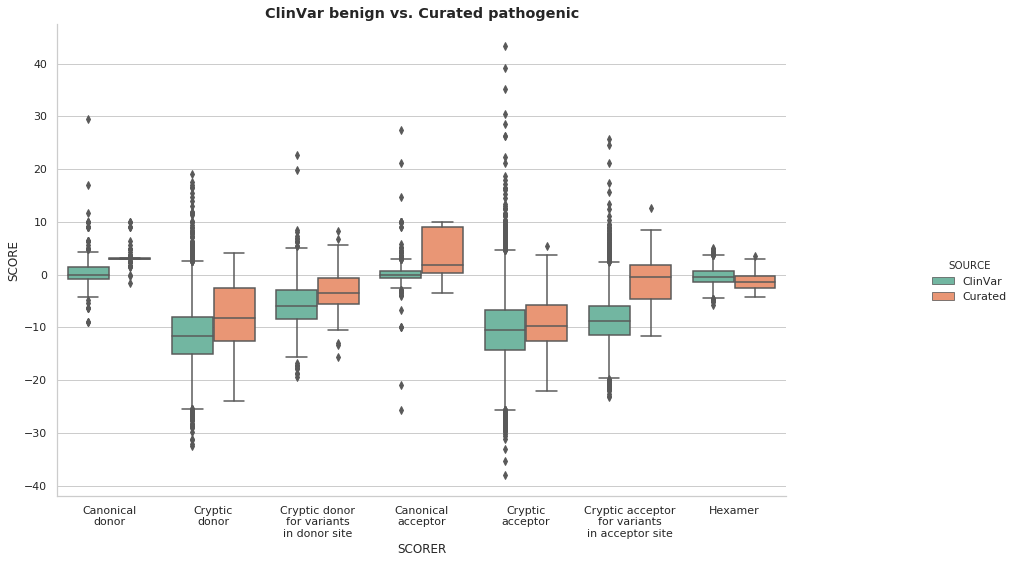

In [6]:
cat = sns.catplot(x="SCORER", y="SCORE", hue="SOURCE", data=joined_melted, kind='box', palette="Set2")
xticklabels = cat.ax.set_xticklabels(SCORER_NAMES)
cat.ax.get_figure().set_size_inches(*figsize)
ax_title = cat.ax.set_title("ClinVar benign vs. Curated pathogenic", size='x-large', weight='bold')

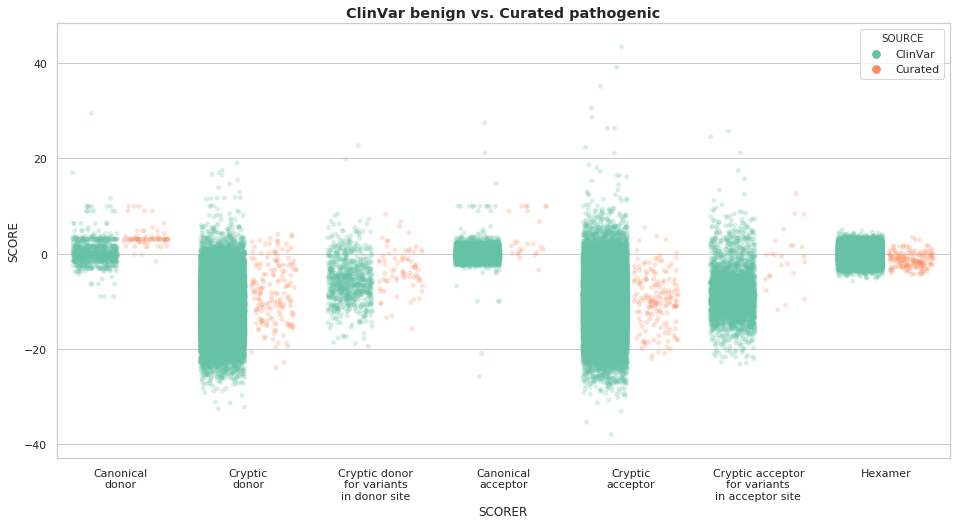

In [7]:
strip = sns.stripplot(x="SCORER", y="SCORE", hue="SOURCE", data=joined_melted, dodge=True, jitter=.35, alpha=.25,
                      palette="Set2")
strip.get_figure().set_size_inches(*figsize)
xticklabels = strip.set_xticklabels(SCORER_NAMES)
ax_title = strip.set_title("ClinVar benign vs. Curated pathogenic", size='x-large', weight='bold')